In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

import scanpy as sc
sc.settings.n_jobs = 56
sc.settings.set_figure_params(dpi=180, dpi_save=300, frameon=False, figsize=(4, 4), fontsize=8, facecolor='white')

import sys
sys.path.append('/home/xingjiepan/Softwares/ZhuangLab/MERFISH_analysis/basic/util')
from plot import get_color_mapping_df, make_frameless_scatter_plot

In [2]:
def merge_clusters(obs_df, cluster_col, clusters_to_merge):
    merged_cluster_id = sorted(clusters_to_merge)[0]
    obs_df[cluster_col][obs_df[cluster_col].isin(clusters_to_merge)] = merged_cluster_id
    obs_df[cluster_col] = obs_df[cluster_col].cat.remove_unused_categories()

In [3]:
import re

def sort_slice_name(slice_names):
    slices = []
    
    for sn in slice_names:
        m = re.search('(.+)_slice([0-9]+)', sn)
        slices.append((m.group(1), int(m.group(2)), sn))    
    
    sorted_slices = sorted(slices, key=lambda x:(x[0], x[1]))
    return [x[2] for x in sorted_slices]

def plot_all_slices(adata, slice_col, color_col, dot_size=1):
    slices = sort_slice_name(np.unique(adata.obs[slice_col]))
    
    N_cols = 5
    N_rows = int(np.ceil(len(slices) / N_cols))

    fig, axes = plt.subplots(N_rows, N_cols, figsize=(3 * N_cols, 3 * N_rows))
    
    for i in range(N_rows):    
        
        for j in range(N_cols):
            idx = N_cols * i + j
            if idx >= len(slices):
                axes[i, j].set_axis_off()
                continue
                
            adata_tmp = adata[adata.obs[slice_col] == slices[idx]]
            axes[i, j].scatter(adata_tmp.obs['center_x'], adata_tmp.obs['center_y'], 
                            c=adata_tmp.obs[color_col], s=dot_size, marker='.',
                            edgecolor='none', rasterized=True)
            
            axes[i, j].set_aspect('equal')
            axes[i, j].set_title(slices[idx])
            axes[i, j].set_axis_off()

In [4]:
# Load the spatial fingerprint anndata
adata_spatial_fingerprint_subclass = sc.read_h5ad('adata_spatial_fingerprint_subclass_raw.h5ad')
#sc.pp.normalize_total(adata_spatial_fingerprint_subclass, target_sum=50)

In [5]:
# Normalize the fingerprint vectors
fp_norms = np.linalg.norm(adata_spatial_fingerprint_subclass.X, axis=1)
adata_spatial_fingerprint_subclass.X = adata_spatial_fingerprint_subclass.X / fp_norms[:, np.newaxis]

In [6]:
%%time
# Generate KNN for the spatial fingerprint vectors
sc.pp.neighbors(adata_spatial_fingerprint_subclass, n_neighbors=30, n_pcs=0)

CPU times: user 2h 36min 58s, sys: 36min 32s, total: 3h 13min 30s
Wall time: 23min 15s


In [7]:
%%time
# Cluster the fingerprint vectors
sc.tl.leiden(adata_spatial_fingerprint_subclass, resolution=0.3)

CPU times: user 9h 27min 36s, sys: 6min 33s, total: 9h 34min 9s
Wall time: 9h 33min 48s


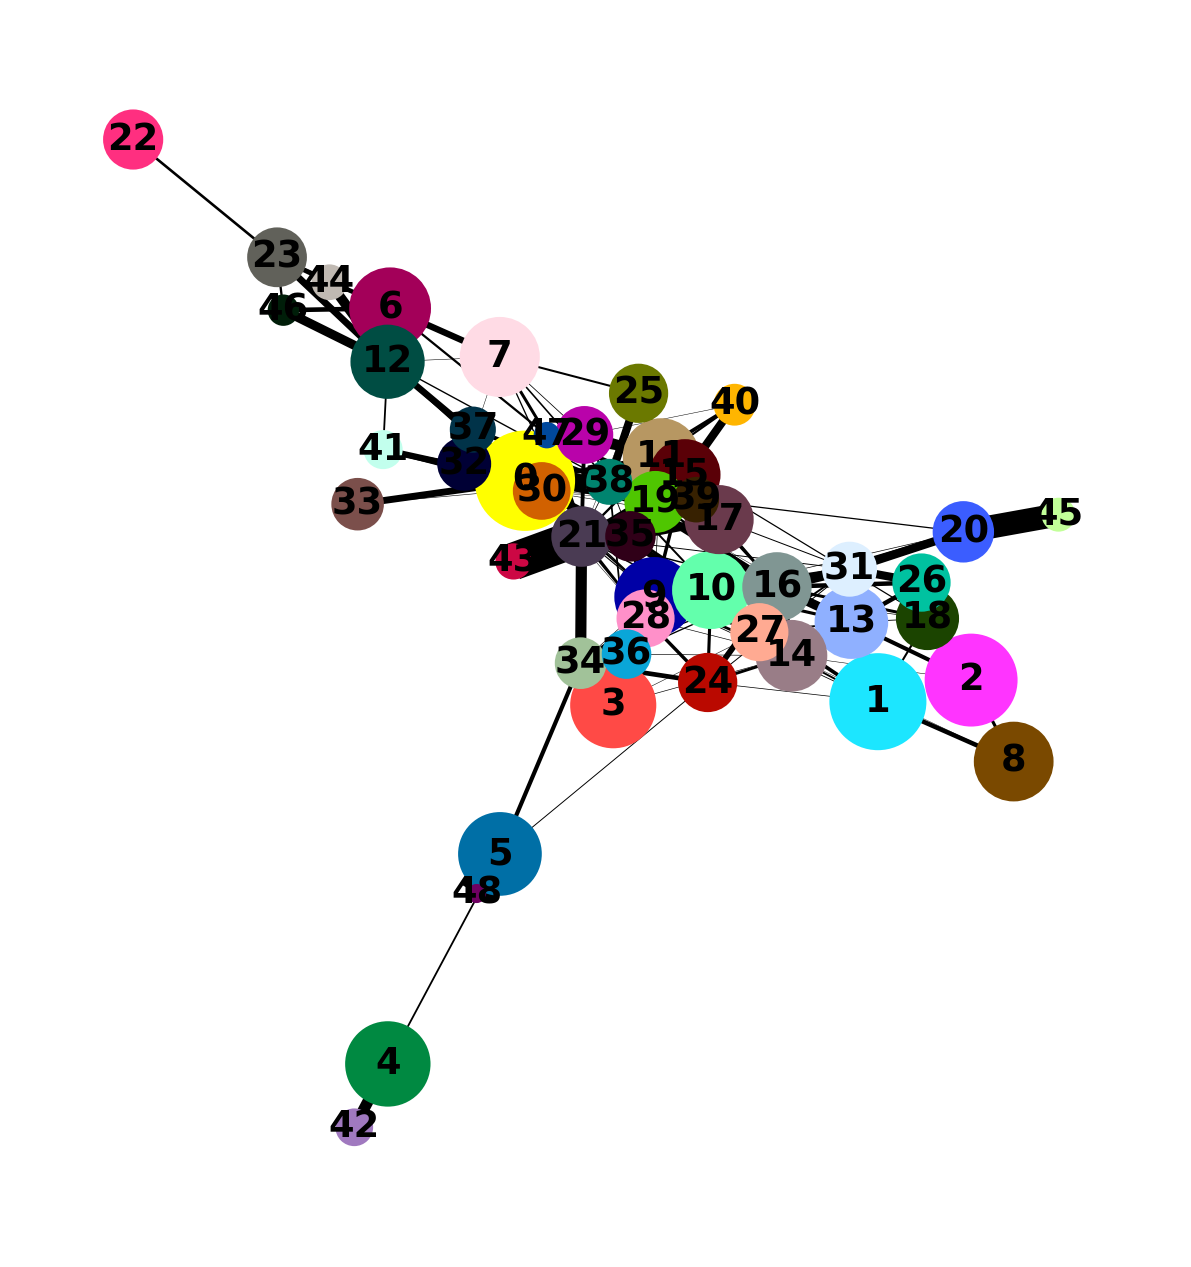

CPU times: user 7min 38s, sys: 19.8 s, total: 7min 57s
Wall time: 7min 57s


In [8]:
%%time
# Generate the PAGA plot for the initial arrangement of the UMAP
sc.tl.paga(adata_spatial_fingerprint_subclass, groups='leiden')
sc.pl.paga(adata_spatial_fingerprint_subclass)

In [9]:
%%time
# Generate UMAP for the spatial modules
sc.tl.umap(adata_spatial_fingerprint_subclass, min_dist=0.1, init_pos='paga')
# Save the UMAP
np.save('X_umap_adata_spatial_knn.npy', adata_spatial_fingerprint_subclass.obsm['X_umap'])

CPU times: user 1h 20min 47s, sys: 1.22 s, total: 1h 20min 49s
Wall time: 1h 20min 44s


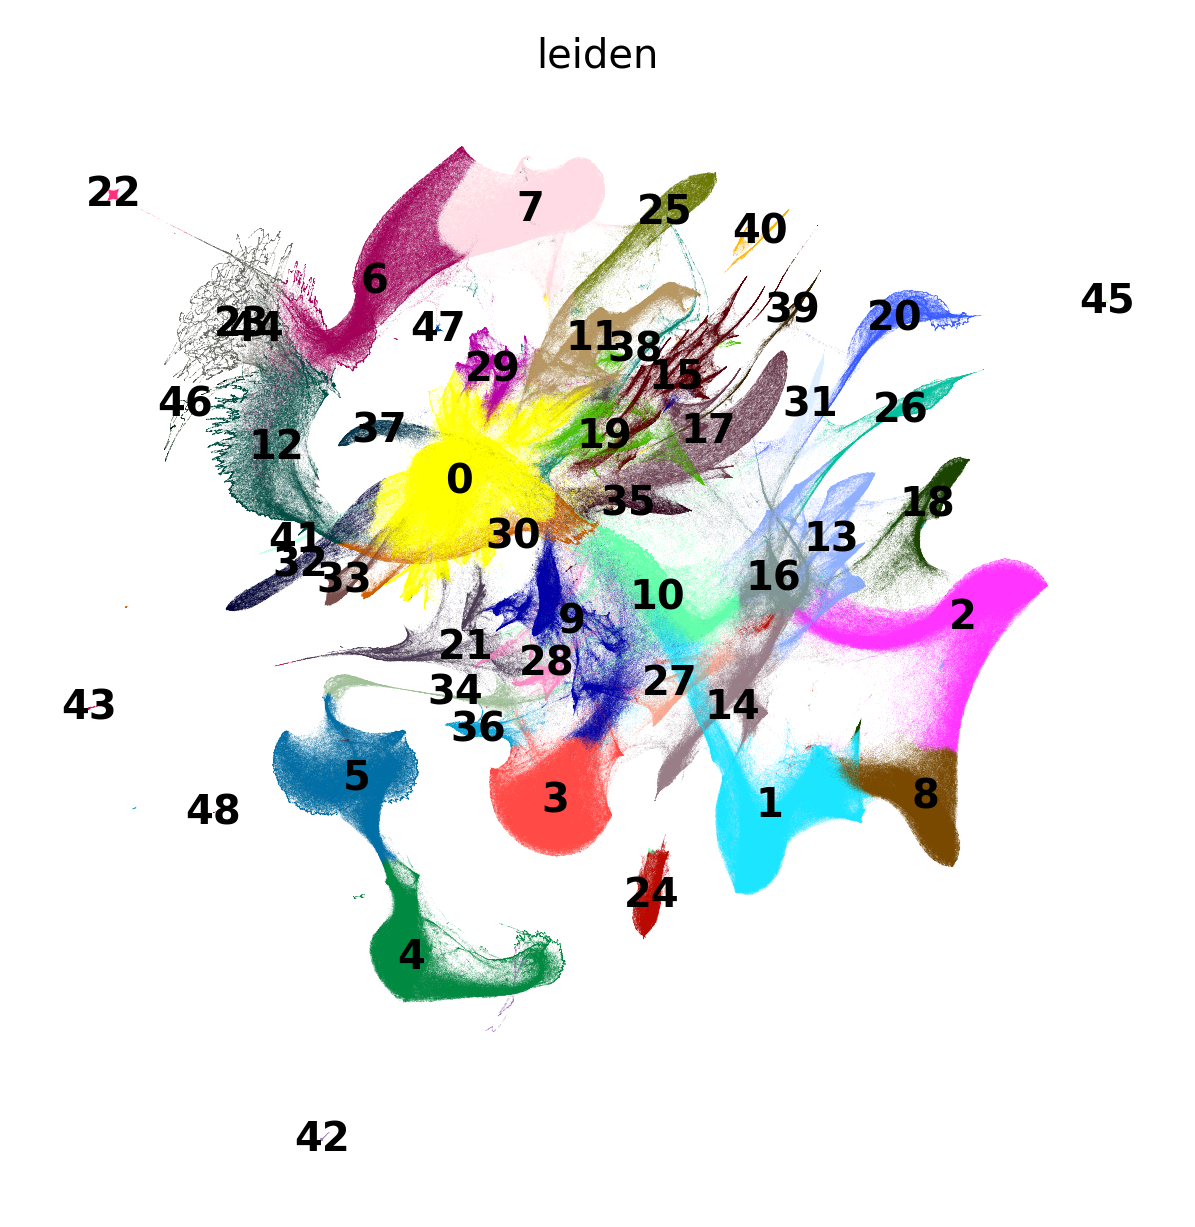

In [10]:
sc.pl.umap(adata_spatial_fingerprint_subclass, color='leiden', legend_loc='on data')

In [11]:
# Save the anndata
adata_spatial_fingerprint_subclass.obs.rename(columns={'leiden': 'spatial_modules_level_1'}, inplace=True)
adata_spatial_fingerprint_subclass.write('adata_spatial_modules_level_1.h5ad')

In [12]:
# assign random colors
cell_types  = np.unique(adata_spatial_fingerprint_subclass.obs['spatial_modules_level_1'])
ct_ids = np.array(list(range(len(cell_types))))
random_colors_rgb = np.random.uniform(size=(len(ct_ids), 3))
random_colors = [matplotlib.colors.to_hex(rgb) for rgb in random_colors_rgb]
color_mapping_df = pd.DataFrame({'cell_type': cell_types, 'colors':random_colors}).set_index('cell_type')

color_mapping_df_merged = adata_spatial_fingerprint_subclass.obs[['spatial_modules_level_1']].merge(
                                    color_mapping_df, 
                                    left_on='spatial_modules_level_1', right_index=True, how='left')
adata_spatial_fingerprint_subclass.obs['colors_sm_level1'] = color_mapping_df_merged['colors']

In [2]:
#make_frameless_scatter_plot(adata_spatial_fingerprint_subclass.obsm['X_umap'][:, 0], 
#                            adata_spatial_fingerprint_subclass.obsm['X_umap'][:, 1], 
#                            adata_spatial_fingerprint_subclass.obs['colors_sm_level1'], size=0.1)

In [1]:
#plot_all_slices(adata_spatial_fingerprint_subclass, 'slice_id', 'colors_sm_level1', dot_size=1)